In [107]:
# Preparing data for training
import numpy as np
import os

# Reading data into a list where each element is one line (string)
input_texts = []
target_texts = []
data_path = 'sample_en-fr.txt'

with open(data_path, 'r', encoding='utf-8') as f:
    for line in f:
        input_texts.append(line.rstrip('\n'))
# input_texts now contains each line as a string
print(f'Read {len(input_texts)} lines from {data_path}')

Read 54 lines from sample_en-fr.txt


In [108]:
input_texts

['hello<EOS>bonjour<EOS>',
 'how are you<EOS>comment ça va<EOS>',
 'i am a student<EOS>je suis étudiant<EOS>',
 'thank you<EOS>merci<EOS>',
 'good morning<EOS>bon matin<EOS>',
 'my friend<EOS>mon ami<EOS>',
 'what is your name<EOS>quel est votre nom<EOS>',
 'i speak english<EOS>je parle anglais<EOS>',
 'do you speak french<EOS>parlez vous français<EOS>',
 'nice to meet you<EOS>enchanté de vous rencontrer<EOS>',
 "where are you from<EOS>d'où venez vous<EOS>",
 "i love paris<EOS>j'aime paris<EOS>",
 'can i help you<EOS>puis je vous aider<EOS>',
 'how much does it cost<EOS>combien ça coûte<EOS>',
 'i am sorry<EOS>je suis désolé<EOS>',
 'see you later<EOS>à bientôt<EOS>',
 'the weather is nice<EOS>le temps est beau<EOS>',
 "i like this book<EOS>j'aime ce livre<EOS>",
 'have you eaten<EOS>avez vous mangé<EOS>',
 "excuse me please<EOS>excusez moi s'il vous plaît<EOS>",
 'what time is it<EOS>quelle heure est il<EOS>',
 'i am happy<EOS>je suis heureux<EOS>',
 "this is delicious<EOS>c'est délic

In [109]:
eng_texts = [] # Encoder input texts
fra_texts = [] # Decoder target texts also, decoder input texts for teacher forcing

for line in input_texts:
    eng, fra, _ = line.split("<EOS>")
    eng_texts.append(eng)
    fra_texts.append(fra)
eng_texts

['hello',
 'how are you',
 'i am a student',
 'thank you',
 'good morning',
 'my friend',
 'what is your name',
 'i speak english',
 'do you speak french',
 'nice to meet you',
 'where are you from',
 'i love paris',
 'can i help you',
 'how much does it cost',
 'i am sorry',
 'see you later',
 'the weather is nice',
 'i like this book',
 'have you eaten',
 'excuse me please',
 'what time is it',
 'i am happy',
 'this is delicious',
 'would you like tea',
 'i need help',
 'good night',
 'where is the bathroom',
 'i am hungry',
 'do you like music',
 'my name is john',
 'can you help me',
 'how old are you',
 'i love you',
 'what is this',
 'this is beautiful',
 'do you have time',
 'i am tired',
 "let's go",
 'good bye',
 'welcome',
 "it's cold today",
 'i understand',
 "i don't understand",
 'please speak slowly',
 'can i sit here',
 'what is the price',
 'i am from america',
 'do you have children',
 'this tastes good',
 'how are you',
 'i am a student',
 'thank you',
 'good morning'

In [110]:
# Tokenize by words and add start/end tokens

encoder_texts = []
decoder_texts = []

for eng in eng_texts:
    encoder_texts.append(eng.strip().lower().split())

for fra in fra_texts:
    decoder_texts.append(['<sos>'] + fra.strip().lower().split() + ['<eos>'])

encoder_texts, decoder_texts


['\tbonjour\n',
 '\tcomment ça va\n',
 '\tje suis étudiant\n',
 '\tmerci\n',
 '\tbon matin\n',
 '\tmon ami\n',
 '\tquel est votre nom\n',
 '\tje parle anglais\n',
 '\tparlez vous français\n',
 '\tenchanté de vous rencontrer\n',
 "\td'où venez vous\n",
 "\tj'aime paris\n",
 '\tpuis je vous aider\n',
 '\tcombien ça coûte\n',
 '\tje suis désolé\n',
 '\tà bientôt\n',
 '\tle temps est beau\n',
 "\tj'aime ce livre\n",
 '\tavez vous mangé\n',
 "\texcusez moi s'il vous plaît\n",
 '\tquelle heure est il\n',
 '\tje suis heureux\n',
 "\tc'est délicieux\n",
 '\tvoulez vous du thé\n',
 "\tj'ai besoin d'aide\n",
 '\tbonne nuit\n',
 '\toù est la salle de bains\n',
 "\tj'ai faim\n",
 '\taimez vous la musique\n',
 '\tmon nom est john\n',
 "\tpouvez vous m'aider\n",
 '\tquel âge avez vous\n',
 "\tje t'aime\n",
 "\tqu'est ce que c'est\n",
 "\tc'est magnifique\n",
 '\tavez vous du temps\n',
 '\tje suis fatigué\n',
 '\tallons y\n',
 '\tau revoir\n',
 '\tbienvenue\n',
 "\til fait froid aujourd'hui\n",
 '\tj

In [ ]:
# Build word-level vocabularies for encoder and decoder

input_tokens = set()
target_tokens = set()

for tokens in encoder_texts:
    for tok in tokens:
        input_tokens.add(tok)

for tokens in decoder_texts:
    for tok in tokens:
        target_tokens.add(tok)

input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

# Vocab sizes and sequence lengths
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)
max_encoder_seq_length = max([len(toks) for toks in encoder_texts])
max_decoder_seq_length = max([len(toks) for toks in decoder_texts])


In [ ]:
# Word token to index mapping

input_token_index = {tok: i for i, tok in enumerate(input_tokens)}
target_token_index = {tok: i for i, tok in enumerate(target_tokens)}


In [113]:
# Initializing the tensors for the inputs

num_samples = len(encoder_texts)

# Encoder input data
encoder_input_data = np.zeros(
    (num_samples, max_encoder_seq_length, num_encoder_tokens),
    dtype="float32"
)

# Decoder input data
decoder_input_data = np.zeros(
    (num_samples, max_decoder_seq_length, num_decoder_tokens),
    dtype="float32"
)

# Decoder target data which is basically one timestep ahead of decoder_input_data for teacher forcing
decoder_target_data = np.zeros(
    (num_samples, max_decoder_seq_length, num_decoder_tokens),
    dtype="float32"
)


In [ ]:
# Filling tensors with one-hot encoded word tokens

for i, (enc_tokens, dec_tokens) in enumerate(zip(encoder_texts, decoder_texts)):
    # Encoder input
    for t, tok in enumerate(enc_tokens):
        if tok in input_token_index:
            encoder_input_data[i, t, input_token_index[tok]] = 1.0

    # Decoder input and target
    for t, tok in enumerate(dec_tokens):
        decoder_input_data[i, t, target_token_index[tok]] = 1.0

        if t > 0:
            # Decoder target shifted by one timestep
            decoder_target_data[i, t - 1, target_token_index[tok]] = 1.0


In [115]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cpu':
    print("I no get GPU :(")

# Convert numpy data to PyTorch tensors
encoder_input_data_torch = torch.FloatTensor(encoder_input_data).to(device)
decoder_input_data_torch = torch.FloatTensor(decoder_input_data).to(device)
decoder_target_data_torch = torch.FloatTensor(decoder_target_data).to(device)

latent_dim = 64  # Latent dimensionality of the encoding space.

# Define Encoder with 2 LSTM layers
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size, latent_dim, batch_first=True)
        self.lstm2 = nn.LSTM(latent_dim, latent_dim, batch_first=True)
    
    def forward(self, x):
        # First LSTM layer
        out1, (h1, c1) = self.lstm1(x)
        # Second LSTM layer
        out2, (h2, c2) = self.lstm2(out1)
        # Return hidden and cell states from the second layer
        return h2, c2

# Define Decoder with 2 LSTM layers
class Decoder(nn.Module):
    def __init__(self, output_size, latent_dim):
        super(Decoder, self).__init__()
        self.lstm1 = nn.LSTM(output_size, latent_dim, batch_first=True)
        self.lstm2 = nn.LSTM(latent_dim, latent_dim, batch_first=True)
        self.dense = nn.Linear(latent_dim, output_size)
    
    def forward(self, x, hidden1, cell1, hidden2, cell2):
        # First LSTM layer
        out1, (h1, c1) = self.lstm1(x, (hidden1, cell1))
        # Second LSTM layer
        out2, (h2, c2) = self.lstm2(out1, (hidden2, cell2))
        # Output layer with softmax
        output = torch.softmax(self.dense(out2), dim=-1)
        return output, h1, c1, h2, c2

# Define the full Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, encoder_input, decoder_input):
        # Encode the input sequence
        encoder_h, encoder_c = self.encoder(encoder_input)
        # For 2-layer LSTM, we need states for both layers
        # Here we use the encoder states for both decoder layers
        decoder_output, _, _, _, _ = self.decoder(decoder_input, encoder_h, encoder_c, encoder_h, encoder_c)
        return decoder_output

# Instantiate the models
encoder = Encoder(num_encoder_tokens, latent_dim).to(device)
decoder = Decoder(num_decoder_tokens, latent_dim).to(device)
model = Seq2Seq(encoder, decoder).to(device)

Using device: cpu
I no get GPU :(


In [116]:
# Training 
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0025)

epochs = 3000
batch_size = 5 
num_batches = len(encoder_input_data_torch) // batch_size
loss_list = []

for epoch in range(epochs):
    total_loss = 0
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        
        encoder_batch = encoder_input_data_torch[start_idx:end_idx]
        decoder_batch = decoder_input_data_torch[start_idx:end_idx]
        target_batch = decoder_target_data_torch[start_idx:end_idx]
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(encoder_batch, decoder_batch)
        
        # Reshape for loss calculation
        # output: (batch_size, seq_length, num_decoder_tokens)
        # target_batch: (batch_size, seq_length, num_decoder_tokens)
        output_reshaped = output.view(-1, num_decoder_tokens)
        target_reshaped = target_batch.view(-1, num_decoder_tokens)
        
        # Loss calculation
        loss = criterion(output_reshaped, target_reshaped)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    loss_list.append(total_loss / num_batches)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / num_batches:.4f}")

print("Done")


Epoch 50/3000, Loss: 1.6466
Epoch 100/3000, Loss: 1.5782
Epoch 150/3000, Loss: 1.5254
Epoch 200/3000, Loss: 1.4818
Epoch 250/3000, Loss: 1.4629
Epoch 300/3000, Loss: 1.4570
Epoch 350/3000, Loss: 1.4523
Epoch 400/3000, Loss: 1.4492
Epoch 450/3000, Loss: 1.4372
Epoch 500/3000, Loss: 1.4295
Epoch 550/3000, Loss: 1.4211
Epoch 600/3000, Loss: 1.4164
Epoch 650/3000, Loss: 1.4135
Epoch 700/3000, Loss: 1.4106
Epoch 750/3000, Loss: 1.4188
Epoch 800/3000, Loss: 1.4063
Epoch 850/3000, Loss: 1.3984
Epoch 900/3000, Loss: 1.3948
Epoch 950/3000, Loss: 1.3931
Epoch 1000/3000, Loss: 1.3912
Epoch 1050/3000, Loss: 1.3901
Epoch 1100/3000, Loss: 1.3866
Epoch 1150/3000, Loss: 1.3861
Epoch 1200/3000, Loss: 1.3848
Epoch 1250/3000, Loss: 1.3823
Epoch 1300/3000, Loss: 1.3767
Epoch 1350/3000, Loss: 1.3758
Epoch 1400/3000, Loss: 1.3721
Epoch 1450/3000, Loss: 1.3703
Epoch 1500/3000, Loss: 1.3691
Epoch 1550/3000, Loss: 1.3668
Epoch 1600/3000, Loss: 1.3662
Epoch 1650/3000, Loss: 1.3696
Epoch 1700/3000, Loss: 1.3628


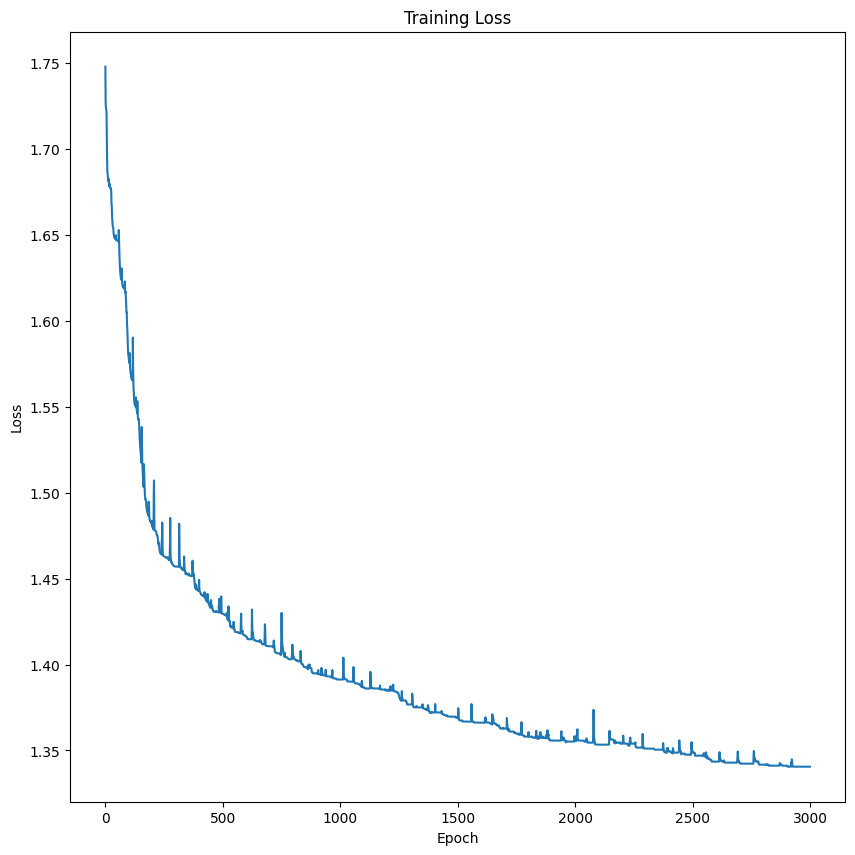

In [117]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [118]:
reverse_target_char_index = {
    i: char for char, i in target_token_index.items()
}

In [119]:
# Set models to evaluation mode
encoder.eval()
decoder.eval()

# Define inference encoder model (returns context from encoder)
class EncoderInference(nn.Module):
    def __init__(self, encoder):
        super(EncoderInference, self).__init__()
        self.encoder = encoder
    
    def forward(self, x):
        h, c = self.encoder(x)
        return h, c

# Define inference decoder model (takes one timestep at a time)
class DecoderInference(nn.Module):
    def __init__(self, decoder):
        super(DecoderInference, self).__init__()
        self.decoder = decoder
    
    def forward(self, x, h1, c1, h2, c2):
        output, h1_new, c1_new, h2_new, c2_new = self.decoder.forward(x, h1, c1, h2, c2)
        return output, h1_new, c1_new, h2_new, c2_new

encoder_inference = EncoderInference(encoder).to(device)
decoder_inference = DecoderInference(decoder).to(device)


In [ ]:
def decode_sequence(input_seq):
    # Encode the input sequence
    input_tensor = torch.FloatTensor(input_seq).to(device)
    
    with torch.no_grad():
        h2, c2 = encoder_inference(input_tensor)
        h1, c1 = h2, c2  # Initialize first layer states same as encoder output
    
    # Generate empty target sequence of length 1.
    target_seq = torch.zeros(1, 1, num_decoder_tokens).to(device)
    # Populate the first token with start token.
    target_seq[0, 0, target_token_index['<sos>']] = 1.0
    
    # Sampling loop
    stop_condition = False
    decoded_tokens = []
    
    while not stop_condition:
        with torch.no_grad():
            output, h1, c1, h2, c2 = decoder_inference(target_seq, h1, c1, h2, c2)
        
        # Sample a token
        sampled_token_index = torch.argmax(output[0, -1, :]).item()
        sampled_token = reverse_target_char_index[sampled_token_index]
        
        if sampled_token == '<eos>' or len(decoded_tokens) >= max_decoder_seq_length:
            stop_condition = True
        else:
            decoded_tokens.append(sampled_token)
        
        # Update the target sequence (of length 1).
        target_seq = torch.zeros(1, 1, num_decoder_tokens).to(device)
        target_seq[0, 0, sampled_token_index] = 1.0
    
    return ' '.join(decoded_tokens)


In [ ]:
def encode_input_sentence(sentence):
    # Tokenize by words
    tokens = sentence.strip().lower().split()
    encoder_input = np.zeros(
        (1, max_encoder_seq_length, num_encoder_tokens),
        dtype="float32"
    )

    for t, tok in enumerate(tokens):
        if tok in input_token_index:
            encoder_input[0, t, input_token_index[tok]] = 1.0

    return encoder_input


In [125]:
english_input = "i am a friend"
input_seq = encode_input_sentence(english_input)

french = decode_sequence(input_seq)
print(french)


je suis désolé



In [123]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (lstm1): LSTM(26, 64, batch_first=True)
    (lstm2): LSTM(64, 64, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(36, 64, batch_first=True)
    (lstm2): LSTM(64, 64, batch_first=True)
    (dense): Linear(in_features=64, out_features=36, bias=True)
  )
)


In [ ]:
## I think i justneed more epochs 
